In [45]:
import pandas as pd
import numpy as np

df_avax = pd.read_csv('AVAXUSDC.csv')
df_ssv = pd.read_csv('SSVUSDT.csv')


In [46]:
_df_avax=df_avax['Close']
_df_ssv=df_ssv['Close']

In [47]:
avax_pct = _df_avax.pct_change()
ssv_pct = _df_ssv.pct_change()

<Axes: title={'center': 'AVAX - SSV'}>

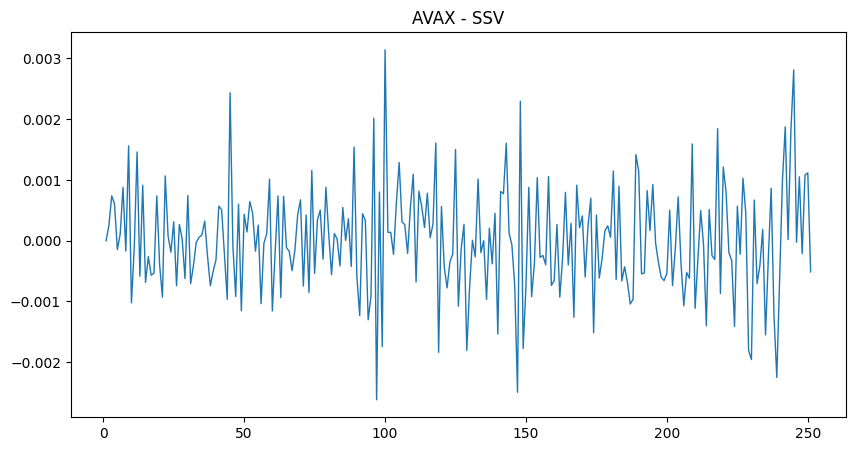

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.title('AVAX - SSV')
(avax_pct - ssv_pct)[0:252].plot(linewidth=1)


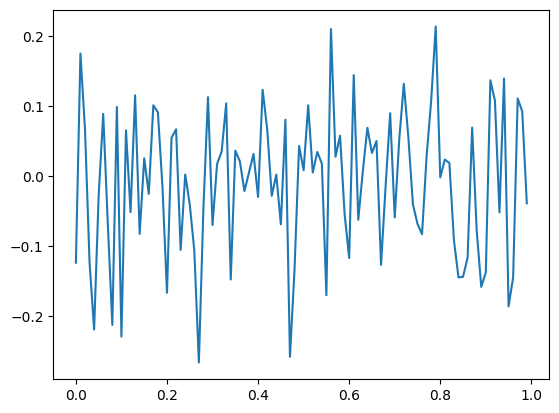

In [27]:
# making artificial data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

T = 1
N = 100
dt = T/N
sqrt_dt = math.sqrt(dt)

t = np.array([i for i in np.arange(0, T, T/N)])
dX = np.random.randn(N) * sqrt_dt
X = np.cumprod(1 + dX)

plt.plot(t, dX)

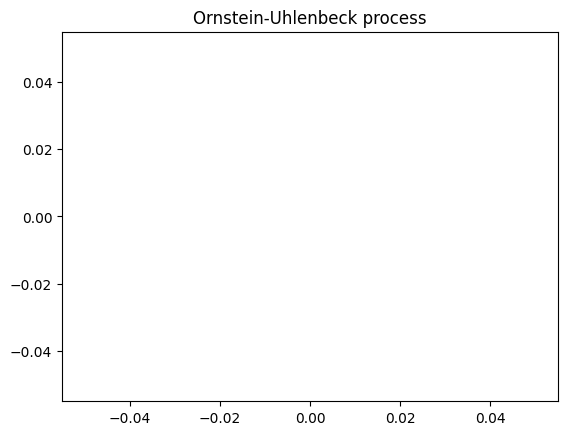

In [50]:
# making OU process data
import numpy as np
import math
import matplotlib.pyplot as plt

T = 1 # total time
N = 43200 # number of steps
mu = 12 # Long term mean
sigma = 1 # Volatility
theta = 0 # Mean reversion speed
dt = T/N

X = avax_pct - ssv_pct

for t in range(1, N):
    dW = np.random.normal(0,1) * math.sqrt(dt)
    X[t] = X[t-1] + theta*(mu - X[t-1])*dt + sigma*dW

plt.plot(np.linspace(0, T, N), X)
plt.title('Ornstein-Uhlenbeck process')
plt.show()

<Axes: >

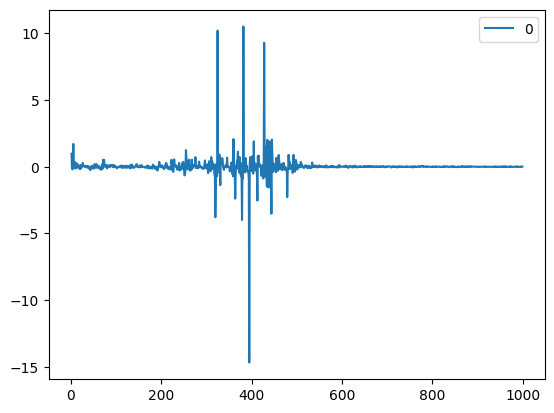

In [44]:
pd.DataFrame(X).pct_change().plot()

In [55]:
_df_avax

0        21.239
1        21.245
2        21.219
3        21.219
4        21.221
          ...  
43195    27.272
43196    27.285
43197    27.255
43198    27.262
43199    27.244
Name: Close, Length: 43200, dtype: float64

In [54]:
_df_ssv

0        17.629
1        17.634
2        17.608
3        17.595
4        17.586
          ...  
43195    23.135
43196    23.144
43197    23.148
43198    23.193
43199    23.150
Name: Close, Length: 43200, dtype: float64

In [62]:
!pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 30.5 MB/s eta 0:00:0000:0100:01


In [83]:
import numpy as np
from tqdm import tqdm

def calculate_emrt(arr: np.array, C: float) -> float:
    s = np.std(arr)
    n = len(arr)
    theta_hat = np.mean(arr)

    # 최대값과 최소값을 저장할 배열을 초기화합니다.
    max_left = np.full(n, -np.inf)  # 현재 위치의 왼쪽에서의 최대값
    max_right = np.full(n, -np.inf)  # 현재 위치의 오른쪽에서의 최대값
    min_left = np.full(n, np.inf)    # 현재 위치의 왼쪽에서의 최소값
    min_right = np.full(n, np.inf)   # 현재 위치의 오른쪽에서의 최소값

    # 각 위치에서의 왼쪽 부분 배열의 최대값과 최소값을 계산합니다.
    print("왼쪽 최대/최소값 계산 중...")
    for m in tqdm(range(1, n)):
        max_left[m] = max(max_left[m-1], arr[m-1])
        min_left[m] = min(min_left[m-1], arr[m-1])

    # 각 위치에서의 오른쪽 부분 배열의 최대값과 최소값을 계산합니다.
    print("오른쪽 최대/최소값 계산 중...")
    for m in tqdm(reversed(range(n-1))):
        max_right[m] = max(max_right[m+1], arr[m+1])
        min_right[m] = min(min_right[m+1], arr[m+1])

    # 임계값을 적용한 기준값을 계산합니다.
    max_left_minus_Cs = max_left - C * s
    max_right_minus_Cs = max_right - C * s
    min_left_plus_Cs = min_left + C * s
    min_right_plus_Cs = min_right + C * s

    # 지역 최소값의 인덱스를 찾습니다.
    print("지역 최소값 찾는 중...")
    local_minima_indices = np.where((arr < max_left_minus_Cs) & (arr < max_right_minus_Cs))[0]

    # 지역 최대값의 인덱스를 찾습니다.
    print("지역 최대값 찾는 중...")
    local_maxima_indices = np.where((arr > min_left_plus_Cs) & (arr > min_right_plus_Cs))[0]

    # 배열의 처음과 끝 인덱스는 제외합니다.
    local_minima_indices = local_minima_indices[(local_minima_indices > 0) & (local_minima_indices < n-1)]
    local_maxima_indices = local_maxima_indices[(local_maxima_indices > 0) & (local_maxima_indices < n-1)]

    print(f"발견된 지역 최소값 개수: {len(local_minima_indices)}")
    print(f"발견된 지역 최대값 개수: {len(local_maxima_indices)}")

    # 지역 극값이 없는 경우 NaN을 반환합니다.
    if len(local_minima_indices) == 0 or len(local_maxima_indices) == 0:
        print("지역 극값이 발견되지 않았습니다.")
        return np.nan

    # 지역 최소값부터 평균값을 다시 교차할 때까지의 시간을 계산합니다.
    print("평균값 재교차 시간 계산 중...")
    reversion_times = []
    for idx in tqdm(local_minima_indices):
        # 평균값을 다시 넘는 지점을 찾습니다.
        next_crossing = np.where(arr[idx:] >= theta_hat)[0]
        if len(next_crossing) > 0:
            reversion_time = next_crossing[0]
            reversion_times.append(reversion_time)
    # 반환할 재귀 시간이 없을 경우 NaN을 반환합니다.
    if len(reversion_times) == 0:
        print("재귀 시간이 계산되지 않았습니다.")
        return np.nan
    # 평균 재귀 시간을 반환합니다.
    mean_reversion_time = np.mean(reversion_times)
    print(f"평균 재귀 시간: {mean_reversion_time}")
    return mean_reversion_time


In [84]:
calculate_emrt(X, 1.5)

왼쪽 최대/최소값 계산 중...


100%|██████████| 43199/43199 [00:00<00:00, 825153.76it/s]


오른쪽 최대/최소값 계산 중...


43199it [00:00, 919376.18it/s]


지역 최소값 찾는 중...
지역 최대값 찾는 중...
발견된 지역 최소값 개수: 21002
발견된 지역 최대값 개수: 33196
평균값 재교차 시간 계산 중...


100%|██████████| 21002/21002 [00:00<00:00, 50196.69it/s]

평균 재귀 시간: 659.6404628130654


np.float64(659.6404628130654)

In [67]:
X = _df_avax - _df_ssv

In [69]:
X = np.array(X)
